In [1]:
import pandas as pd
import numpy as np

import os
import glob

import re

pd.options.display.max_columns = None

import os
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## **Data Understanding**

Ini adalah dataset publik e-commerce Brasil dari pesanan yang dibuat di Olist Store. Dataset ini memiliki informasi dari 100 ribu pesanan dari tahun 2016 hingga 2018 yang dibuat di beberapa pasar di Brasil. Fitur-fiturnya memungkinkan untuk melihat pesanan dari berbagai dimensi: mulai dari status pesanan, harga, pembayaran, dan kinerja pengiriman hingga lokasi pelanggan, atribut produk, dan akhirnya ulasan yang ditulis oleh pelanggan. Selain itu ada juga dataset geolokasi yang menghubungkan kode pos Brasil dengan koordinat lintang/lintang.

### **Data Schema**

Data dibagi dalam beberapa dataset. Skema data bisa dilihat pada gambar berikut:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/ERD.jpg" alt ="Scheme Data Table" width = 900; height = 647></center>
  <figcaption align = "center">Gambar 1. <em>Scheme Data</em> </figcaption>
</figure>
<p> <p>

### **Feature Description**

Berikut adalah fitur-fitur yang tersedia dalam dataset:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/Olist-Dataset-Description.jpg" alt ="Scheme Data Table" width = 900; height = 1056></center>
  <figcaption align = "center">Gambar 2. <em>Deskripsi Feature</em> </figcaption>
</figure>
<p> <p>

### **Data Skimming**

In [2]:
# load data
RAW_DATA_DIR = r"..\data\raw"
file_list = glob.glob(RAW_DATA_DIR + "\*.csv")

In [3]:
# function text handling
def efn(text):
    file = text.split('\\')[-1].replace('.csv','')
    return file

def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
# create dictionary of dataset
dfs = {f'{efn(file)}': white_string_to_nan(pd.read_csv(file, engine="pyarrow")) for file in file_list}

In [5]:
# check data info
dataInfo = []

for n in dfs.keys():
    dataInfo.append({
        'dataset_name' : n,
        'shape' : dfs[n].shape,
        'columns' : list(dfs[n].columns),
        'duplicate' : dfs[n].duplicated().sum(),
        'null' : dfs[n].isna().sum().sum(),
        'null_columns' : dfs[n].columns[dfs[n].isna().any()].tolist()
    })

pd.DataFrame(dataInfo)

dataset_name         shape  \
0            olist_customers_dataset    (99441, 5)   
1          olist_geolocation_dataset  (1000163, 5)   
2               olist_orders_dataset    (99441, 8)   
3          olist_order_items_dataset   (112650, 7)   
4       olist_order_payments_dataset   (103886, 5)   
5        olist_order_reviews_dataset    (99224, 7)   
6             olist_products_dataset    (32951, 9)   
7              olist_sellers_dataset     (3095, 4)   
8  product_category_name_translation       (71, 2)   

                                             columns  duplicate    null  \
0  [customer_id, customer_unique_id, customer_zip...          0       0   
1  [geolocation_zip_code_prefix, geolocation_lat,...     261831       0   
2  [order_id, customer_id, order_status, order_pu...          0    4908   
3  [order_id, order_item_id, product_id, seller_i...          0       0   
4  [order_id, payment_sequential, payment_type, p...          0       0   
5  [review_id, order_id, review_score, review_com...          0  145932   
6  [product_id, product_category_name, product_na...          0    2448   
7  [seller_id, seller_zip_code_prefix, seller_cit...          0       0   
8  [product_category_name, product_category_name_...          0       0   

                                        null_columns  
0                                                 []  
1                                                 []  
2  [order_approved_at, order_delivered_carrier_da...  
3                                                 []  
4                                                 []  
5     [review_comment_title, review_comment_message]  
6  [product_category_name, product_name_lenght, p...  
7                                                 []  
8                                                 []

In [6]:
# skimming function
def skim(data, name):
    summary = pd.DataFrame({
                'dataset' : name,
                'column': data.columns.values,
                'type': data.dtypes.values,
                'unique': data.nunique().values,
                'null': data.isna().sum().reset_index()[0],
                'null_pct': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                'min': data.dropna().min().values,
                'max': data.dropna().max().values
                })
    return summary

# check
pd.concat([skim(dfs[n], n) for n in dfs.keys()], sort=False, ignore_index=True)

dataset                         column  \
0            olist_customers_dataset                    customer_id   
1            olist_customers_dataset             customer_unique_id   
2            olist_customers_dataset       customer_zip_code_prefix   
3            olist_customers_dataset                  customer_city   
4            olist_customers_dataset                 customer_state   
0          olist_geolocation_dataset    geolocation_zip_code_prefix   
1          olist_geolocation_dataset                geolocation_lat   
2          olist_geolocation_dataset                geolocation_lng   
3          olist_geolocation_dataset               geolocation_city   
4          olist_geolocation_dataset              geolocation_state   
0               olist_orders_dataset                       order_id   
1               olist_orders_dataset                    customer_id   
2               olist_orders_dataset                   order_status   
3               olist_orders_dataset       order_purchase_timestamp   
4               olist_orders_dataset              order_approved_at   
5               olist_orders_dataset   order_delivered_carrier_date   
6               olist_orders_dataset  order_delivered_customer_date   
7               olist_orders_dataset  order_estimated_delivery_date   
0          olist_order_items_dataset                       order_id   
1          olist_order_items_dataset                  order_item_id   
2          olist_order_items_dataset                     product_id   
3          olist_order_items_dataset                      seller_id   
4          olist_order_items_dataset            shipping_limit_date   
5          olist_order_items_dataset                          price   
6          olist_order_items_dataset                  freight_value   
0       olist_order_payments_dataset                       order_id   
1       olist_order_payments_dataset             payment_sequential   
2       olist_order_payments_dataset                   payment_type   
3       olist_order_payments_dataset           payment_installments   
4       olist_order_payments_dataset                  payment_value   
0        olist_order_reviews_dataset                      review_id   
1        olist_order_reviews_dataset                       order_id   
2        olist_order_reviews_dataset                   review_score   
3        olist_order_reviews_dataset           review_comment_title   
4        olist_order_reviews_dataset         review_comment_message   
5        olist_order_reviews_dataset           review_creation_date   
6        olist_order_reviews_dataset        review_answer_timestamp   
0             olist_products_dataset                     product_id   
1             olist_products_dataset          product_category_name   
2             olist_products_dataset            product_name_lenght   
3             olist_products_dataset     product_description_lenght   
4             olist_products_dataset             product_photos_qty   
5             olist_products_dataset               product_weight_g   
6             olist_products_dataset              product_length_cm   
7             olist_products_dataset              product_height_cm   
8             olist_products_dataset               product_width_cm   
0              olist_sellers_dataset                      seller_id   
1              olist_sellers_dataset         seller_zip_code_prefix   
2              olist_sellers_dataset                    seller_city   
3              olist_sellers_dataset                   seller_state   
0  product_category_name_translation          product_category_name   
1  product_category_name_translation  product_category_name_english   

             type  unique   null  null_pct  \
0          object   99441      0      0.00   
1          object   96096      0      0.00   
2           int64   14994      0      0.00   
3          object    4119      0      0.00   
4          object      27      0   

**Insights**:
* Terdapat duplikasi data (berdasarkan seluruh kolom) di **olist_geolocation_dataset** yang akan diteliti lebih lanjut
* Terdapat missing values di:
    * **olist_orders_dataset** pada kolom: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date
    * **olist_order_reviews** pada kolom: review_message_title, review_message_comment
    * **olist_products_dataset** pada kolom: product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm
<br>
* Handling missing values akan dilakukan setelah merging dataset
* Tipe data:
    * IDs (6):
        * customer_unique_id
        * customer_id
        * order_id
        * order_item_id
        * review_id
        * product_id
        * seller_id
<br>
    * Categorical (7):
        * order_status, low cardinality (8)
        * product_category_name, high cardinality (72)
        * product_category_name_english, high cardinality (72)
        * customer_zip_code_prefix, high cardinality (14994)
        * customer_city, high cardinality (4119)
        * customer_state, high cardinality (27)
        * payment_type, low cardinality low (5)
<br>
    * Datetime (6):
        * order_purchase_timestamp
        * order_approved_at
        * order_delivered_carrier_date
        * order_delivered_customer_date
        * order_estimated_delivery_date
        * shipping_limit_date
<br>
    * Numerical, Continuous (3):
        * price
        * freight_value
        * payment_value
<br>
    * Numerical, Ordinal (3):
        * review_score
        * payment_sequential, high cardinality (26)
        * payment_installments, high cardinality (24)

#### **olist_customers_dataset**

In [7]:
customers = dfs["olist_customers_dataset"]

In [8]:
customers[customers.duplicated(subset=["customer_unique_id"], keep=False)].sort_values(by=["customer_unique_id"], ignore_index=True)

customer_id                customer_unique_id  \
0     24b0e2bd287e47d54d193e7bbb51103f  00172711b30d52eea8b313a7f2cced02   
1     1afe8a9c67eec3516c09a8bdcc539090  00172711b30d52eea8b313a7f2cced02   
2     1b4a75b3478138e99902678254b260f4  004288347e5e88a27ded2bb23747066c   
3     f6efe5d5c7b85e12355f9d5c3db46da2  004288347e5e88a27ded2bb23747066c   
4     49cf243e0d353cd418ca77868e24a670  004b45ec5c64187465168251cd1c9c2f   
...                                ...                               ...   
6337  1ae563fdfa500d150be6578066d83998  ff922bdd6bafcdf99cb90d7f39cea5b3   
6338  bec0bf00ac5bee64ce8ef5283051a70c  ff922bdd6bafcdf99cb90d7f39cea5b3   
6339  d064be88116eb8b958727aec4cf56a59  ff922bdd6bafcdf99cb90d7f39cea5b3   
6340  4b231c90751c27521f7ee27ed2dc3b8f  ffe254cc039740e17dd15a5305035928   
6341  0088395699ea0fcd459bfbef084997db  ffe254cc039740e17dd15a5305035928   

      customer_zip_code_prefix customer_city customer_state  
0                        45200        jequie             BA  
1                        45200        jequie             BA  
2                        26220   nova iguacu             RJ  
3                        26220   nova iguacu             RJ  
4                        57055        maceio             AL  
...                        ...           ...            ...  
6337                     17340  barra bonita             SP  
6338                     17340  barra bonita             SP  
6339                     17340  barra bonita             SP  
6340                     37640       extrema             MG  
6341                     37640       extrema             MG  

[6342 rows x 5 columns]

#### **olist_geolocation_dataset**

In [9]:
geolocation = dfs["olist_geolocation_dataset"]

In [10]:
geolocation[geolocation.duplicated(keep=False)].sort_values(by=["geolocation_zip_code_prefix", "geolocation_lat"], ignore_index=True)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                              1001       -23.551337       -46.634027   
1                              1001       -23.551337       -46.634027   
2                              1001       -23.551337       -46.634027   
3                              1001       -23.550498       -46.634338   
4                              1001       -23.550498       -46.634338   
...                             ...              ...              ...   
390000                        99980       -28.387432       -51.847727   
390001                        99980       -28.387059       -51.848964   
390002                        99980       -28.387059       -51.848964   
390003                        99980       -28.386689       -51.847091   
390004                        99980       -28.386689       -51.847091   

       geolocation_city geolocation_state  
0             sao paulo                SP  
1             sao paulo                SP  
2             sao paulo                SP  
3             sao paulo                SP  
4             sao paulo                SP  
...                 ...               ...  
390000  david canabarro                RS  
390001  david canabarro                RS  
390002  david canabarro                RS  
390003  david canabarro                RS  
390004  david canabarro                RS  

[390005 rows x 5 columns]

#### **olist_orders_dataset_df**

In [11]:
orders = dfs["olist_orders_dataset"]

In [12]:
orders[orders.isna().values]["order_status"].value_counts().reset_index()

order_status  count
0     canceled   1310
1  unavailable   1218
2      shipped   1107
3     invoiced    628
4   processing    602
5    delivered     24
6      created     15
7     approved      4

#### **olist_order_items_dataset**

In [13]:
order_items = dfs["olist_order_items_dataset"]

In [14]:
order_items[order_items.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "order_item_id"], ignore_index=True)

order_id  order_item_id  \
0      0008288aa423d2a3f00fcb17cd7d8719              1   
1      0008288aa423d2a3f00fcb17cd7d8719              2   
2      00143d0f86d6fbd9f9b38ab440ac16f5              1   
3      00143d0f86d6fbd9f9b38ab440ac16f5              2   
4      00143d0f86d6fbd9f9b38ab440ac16f5              3   
...                                 ...            ...   
23782  fff8287bbae429a99bb7e8c21d151c41              2   
23783  fffb9224b6fc7c43ebb0904318b10b5f              1   
23784  fffb9224b6fc7c43ebb0904318b10b5f              2   
23785  fffb9224b6fc7c43ebb0904318b10b5f              3   
23786  fffb9224b6fc7c43ebb0904318b10b5f              4   

                             product_id                         seller_id  \
0      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
1      368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
2      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
3      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
4      e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
...                                 ...                               ...   
23782  bee2e070c39f3dd2f6883a17a5f0da45  4e922959ae960d389249c378d1c939f5   
23783  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
23784  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
23785  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   
23786  43423cdffde7fda63d0414ed38c11a73  b1fc4f64df5a0e8b6913ab38803c57a9   

      shipping_limit_date   price  freight_value  
0     2018-02-21 02:55:52   49.90          13.37  
1     2018-02-21 02:55:52   49.90          13.37  
2     2017-10-20 16:07:52   21.33          15.10  
3     2017-10-20 16:07:52   21.33          15.10  
4     2017-10-20 16:07:52   21.33          15.10  
...                   ...     ...            ...  
23782 2018-03-27 12:29:22  180.00          48.14  
23783 2017-11-03 02:55:58   55.00          34.19  
23784 2017-11-03 02:55:58   55.00          34.19  
23785 2017-11-03 02:55:58   55.00          34.19  
23786 2017-11-03 02:55:58   55.00          34.19  

[23787 rows x 7 columns]

In [15]:
order_items[order_items["freight_value"]==0]

order_id  order_item_id  \
114     00404fa7a687c8c44ca69d42695aae73              1   
258     00a870c6c06346e85335524935c600c0              1   
483     011c899816ea29773525bd3322dbb6aa              1   
508     012b3f6ab7776a8ab3443a4ad7bef2e6              1   
509     012b3f6ab7776a8ab3443a4ad7bef2e6              2   
...                                  ...            ...   
111094  fc698f330ec7fb74859071cc6cb29772              1   
111497  fd4907109f6bac23f07064af84bec02d              1   
111649  fd95e4b85ebbb81853d4a6be3d61432b              1   
112182  fee19a0dc7358b6962a611cecf6a37b4              1   
112607  ffe73fc1d73e03fdb50e63903ddfe882              1   

                              product_id                         seller_id  \
114     53b36df67ebb7c41585e8d54d6772e08  7d13fca15225358621be4086e1eb0964   
258     aca2eb7d00ea1a7b8ebd4e68314663af  955fee9216a65b617aa5c0531780ce60   
483     53b36df67ebb7c41585e8d54d6772e08  7d13fca15225358621be4086e1eb0964   
508     422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
509     422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
...                                  ...                               ...   
111094  422879e10f46682990de24d770e7f83d  1f50f920176fa81dab994f9023523100   
111497  7a10781637204d8d10485c71a6108a2e  4869f7a5dfa277a7dca6462dcf3b52b2   
111649  53b36df67ebb7c41585e8d54d6772e08  4869f7a5dfa277a7dca6462dcf3b52b2   
112182  f1c7f353075ce59d8a6f3cf58f419c9c  37be5a7c751166fbc5f8ccba4119e043   
112607  53b36df67ebb7c41585e8d54d6772e08  4869f7a5dfa277a7dca6462dcf3b52b2   

       shipping_limit_date  price  freight_value  
114    2018-05-15 04:31:26   99.9            0.0  
258    2018-05-14 00:14:29   69.9            0.0  
483    2018-05-07 05:30:45   99.9            0.0  
508    2018-05-09 21:30:50   53.9            0.0  
509    2018-05-09 21:30:50   53.9            0.0  
...                    ...    ...            ...  
111094 2018-04-25 02:31:57   53.9            0.0  
111497 2018-04-30 11:31:32  219.0            0.0  
111649 2018-05-04 11:10:31  106.9            0.0  
112182 2017-09-07 22:06:31  195.0            0.0  
112607 2018-04-23 13:15:15  112.9            0.0  

[383 rows x 7 columns]

#### **olist_order_payments_dataset**

In [16]:
order_payments = dfs["olist_order_payments_dataset"]

In [17]:
order_payments[order_payments.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "payment_sequential"], ignore_index=True)

order_id  payment_sequential payment_type  \
0     0016dfedd97fc2950e388d2971d718c7                   1  credit_card   
1     0016dfedd97fc2950e388d2971d718c7                   2      voucher   
2     002f19a65a2ddd70a090297872e6d64e                   1      voucher   
3     002f19a65a2ddd70a090297872e6d64e                   2      voucher   
4     0071ee2429bc1efdc43aa3e073a5290e                   1      voucher   
...                                ...                 ...          ...   
7402  ffa1dd97810de91a03abd7bd76d2fed1                   2      voucher   
7403  ffa39020fe7c8a3e907320e1bec4b985                   1  credit_card   
7404  ffa39020fe7c8a3e907320e1bec4b985                   2      voucher   
7405  ffc730a0615d28ec19f9cad02cb41442                   1  credit_card   
7406  ffc730a0615d28ec19f9cad02cb41442                   2  credit_card   

      payment_installments  payment_value  
0                        5          52.63  
1                        1          17.92  
2                        1          44.11  
3                        1          33.18  
4                        1         100.00  
...                    ...            ...  
7402                     1         418.73  
7403                     1           7.13  
7404                     1          64.01  
7405                     1          14.76  
7406                     1          12.63  

[7407 rows x 5 columns]

In [18]:
order_payments[order_payments["payment_installments"]==0]

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   2  credit_card   
79014  1a57108394169c0b47d8f876acc9ba2d                   2  credit_card   

       payment_installments  payment_value  
46982                     0          58.69  
79014                     0         129.94

In [19]:
order_payments[order_payments["payment_value"]==0]

order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  
57411                      1            0.0  
62674                      1            0.0  
77885                      1            0.0  
94427                      1            0.0  
100766                     1            0.0

#### **olist_order_reviews_dataset**

In [20]:
order_reviews = dfs["olist_order_reviews_dataset"]

In [21]:
order_reviews[order_reviews.duplicated(subset=["review_id"], keep=False)].sort_values(by=["review_id"])

review_id                          order_id  \
46678  00130cbe1f9d422698c812ed8ded1919  dfcdfc43867d1c1381bfaf62d6b9c195   
29841  00130cbe1f9d422698c812ed8ded1919  04a28263e085d399c97ae49e0b477efa   
90677  0115633a9c298b6a98bcbe4eee75345f  78a4201f58af3463bdab842eea4bc801   
63193  0115633a9c298b6a98bcbe4eee75345f  0c9850b2c179c1ef60d2855e2751d1fa   
92876  0174caf0ee5964646040cd94e15ac95e  f93a732712407c02dce5dd5088d0f47b   
...                                 ...                               ...   
31120  fe5c833752953fed3209646f1f63b53c  4863e15fa53273cc7219c58f5ffda4fb   
7870   ff2fc9e68f8aabfbe18d710b83aabd30  2da58e0a7dcfa4ce1e00fad9d03ca3b5   
82521  ff2fc9e68f8aabfbe18d710b83aabd30  1078d496cc6ab9a8e6f2be77abf5091b   
73951  ffb8cff872a625632ac983eb1f88843c  c44883fc2529b4aa03ca90e7e09d95b6   
1985   ffb8cff872a625632ac983eb1f88843c  c88b1d1b157a9999ce368f218a407141   

       review_score review_comment_title  \
46678             1                  NaN   
29841             1                  NaN   
90677             5                  NaN   
63193             5                  NaN   
92876             1                  NaN   
...             ...                  ...   
31120             1                  NaN   
7870              2                  NaN   
82521             2                  NaN   
73951             3                  NaN   
1985              3                  NaN   

                                  review_comment_message review_creation_date  \
46678  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   
29841  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   
90677                                                NaN           2017-09-21   
63193                                                NaN           2017-09-21   
92876  Produto entregue dentro de embalagem do fornec...           2018-03-07   
...                                                  ...                  ...   
31120  Comprei dois produtos e ambos, mesmo enviados ...           2018-02-28   
7870                                                 NaN           2018-03-17   
82521                                                NaN           2018-03-17   
73951                                                NaN           2017-07-22   
1985                                                 NaN           2017-07-22   

      review_answer_timestamp  
46678     2018-03-20 18:08:23  
29841     2018-03-20 18:08:23  
90677     2017-09-26 03:27:47  
63193     2017-09-26 03:27:47  
92876     2018-03-08 03:00:53  
...                       ...  
31120     2018-02-28 13:57:52  
7870      2018-03-19 11:44:15  
82521     2018-03-19 11:44:15  
73951     2017-07-26 13:41:07  
1985      2017-07-26 13:41:07  

[1603 rows x 7 columns]

In [22]:
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id"])

review_id                          order_id  \
25612  89a02c45c340aeeb1354a24e7d4b2c1e  0035246a40f520710769010f752e7507   
22423  2a74b0559eb58fc1ff842ecc999594cb  0035246a40f520710769010f752e7507   
22779  ab30810c29da5da8045216f0f62652a2  013056cfe49763c6f66bda03396c5ee3   
68633  73413b847f63e02bc752b364f6d05ee9  013056cfe49763c6f66bda03396c5ee3   
854    830636803620cdf8b6ffaf1b2f6e92b2  0176a6846bcb3b0d3aa3116a9a768597   
...                                 ...                               ...   
27465  5e78482ee783451be6026e5cf0c72de1  ff763b73e473d03c321bcd5a053316e8   
41355  39de8ad3a1a494fc68cc2d5382f052f4  ff850ba359507b996e8b2fbb26df8d03   
18783  80f25f32c00540d49d57796fb6658535  ff850ba359507b996e8b2fbb26df8d03   
92230  870d856a4873d3a67252b0c51d79b950  ffaabba06c9d293a3c614e0515ddbabc   
53962  5476dd0eaee7c4e2725cafb011aa758c  ffaabba06c9d293a3c614e0515ddbabc   

       review_score review_comment_title  \
25612             5                  NaN   
22423             5                  NaN   
22779             5                  NaN   
68633             4                  NaN   
854               5                  NaN   
...             ...                  ...   
27465             3                  NaN   
41355             5                  NaN   
18783             5                  NaN   
92230             3                  NaN   
53962             3                  NaN   

                                  review_comment_message review_creation_date  \
25612                                                NaN           2017-08-29   
22423  Estou acostumada a comprar produtos pelo barat...           2017-08-25   
22779                                                NaN           2018-02-22   
68633                                                NaN           2018-03-04   
854                                                  NaN           2017-12-30   
...                                                  ...                  ...   
27465  Não sei que haverá acontecido os demais chegaram            2017-11-18   
41355                       Envio rapido... Produto 100%           2017-08-16   
18783  Envio rapido, produto conforme descrito no anu...           2017-08-22   
92230                                                NaN           2017-12-20   
53962                                                NaN           2017-12-20   

      review_answer_timestamp  
25612     2017-08-30 01:59:12  
22423     2017-08-29 21:45:57  
22779     2018-02-23 12:12:30  
68633     2018-03-05 17:02:00  
854       2018-01-02 10:54:06  
...                       ...  
27465     2017-11-18 09:02:48  
41355     2017-08-17 11:56:55  
18783     2017-08-25 11:40:22  
92230     2017-12-20 18:50:16  
53962     2017-12-21 13:24:55  

[1098 rows x 7 columns]

**Insight**:
* Duplicated values di kolom review_id dan order_id
* Asumsi duplicated values di kolom review_id terjadi ketika customer melakukan review untuk beberapa order dalam satu waktu, tidak perlu handling lebih lanjut
* Asumsi duplicated values di kolom order_id terjadi ketika customer berubah pikiran dari review yang sebelumnya sudah dibuat, **solusi: mengambil review terbaru berdasarkan kolom review_answer_timestamp**

#### **olist_products_dataset_df**

In [23]:
products = dfs["olist_products_dataset"]

In [24]:
[category for category in products.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

#### **olist_sellers_dataset_df**

In [25]:
sellers = dfs["olist_sellers_dataset"]

#### **product_category_name_translation_df**

In [27]:
category_translation = dfs["product_category_name_translation"]

In [28]:
[category for category in category_translation.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

**Insight:**
<br>Ada duplikasi kategori yaitu eletrodomesticos_2 dan casa_conforto_2, **solusi: kedua kategori akan diganti menjadi eletrodomesticos dan casa_conforto**

## **Data Cleaning**

#### Missing Product Category Translation

In [29]:
missing_translation = pd.DataFrame({"product_category_name": ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                                    "product_category_name_english": ["pc_gamer", "portable_kitchen_and_food_processors"]})
category_translation = pd.concat([category_translation, missing_translation], ignore_index=True)

#### Duplicate Product Category

In [30]:
products.replace(to_replace="_2", value="", regex=True, inplace=True)
product_category_translation = category_translation[~category_translation["product_category_name"].str.contains("_2")]

product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_tmp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
skim(merged_tmp, "merged_product_category")

dataset                         column    type  unique  \
0  merged_product_category          product_category_name  object      71   
1  merged_product_category  product_category_name_english  object      71   

   null  null_pct                         min                    max  
0     0       0.0   agro_industria_e_comercio  utilidades_domesticas  
1     0       0.0  agro_industry_and_commerce          watches_gifts

#### Zero Payment Installments

In [31]:
order_payments["payment_installments"].replace(0, 1, inplace=True)
order_payments[order_payments["payment_installments"]==0]

Empty DataFrame
Columns: [order_id, payment_sequential, payment_type, payment_installments, payment_value]
Index: []

#### Duplicate Order Reviews

In [32]:
order_reviews.drop_duplicates(subset=["order_id"], keep="last", ignore_index=True, inplace=True)
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)]

Empty DataFrame
Columns: [review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp]
Index: []

### **Merge Datasets**

#### Customers

In [33]:
master_data = customers[["customer_unique_id", "customer_id"]].merge(orders, on="customer_id", how="left")
master_data.shape

(99441, 9)

#### Orders, Order Items

In [34]:
master_data = master_data.merge(order_items, on="order_id", how="left")
master_data.shape

(113425, 15)

#### Products

In [35]:
master_data = master_data.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
master_data.shape

(113425, 16)

#### Product Category Translation

In [36]:
master_data = master_data.merge(product_category_translation, on="product_category_name", how="left")
master_data.shape

(113425, 17)

#### Order Payments

In [37]:
master_data = master_data.merge(order_payments, on="order_id", how="left")
master_data.shape

(118434, 21)

#### Order Reviews

In [38]:
master_data = master_data.merge(order_reviews[["order_id", "review_score"]], on="order_id", how="left")
master_data.shape

(118434, 22)

In [39]:
master_data.sort_values(by=["order_purchase_timestamp", "customer_unique_id", "order_id", "order_item_id", "payment_sequential"], inplace=True, ignore_index=True)
master_data.head(10)

customer_unique_id                       customer_id  \
0  b7d76e111c89f7ebf14761390f0f7d17  08c5351a6aca1c1589a38f244edeee9d   
1  b7d76e111c89f7ebf14761390f0f7d17  08c5351a6aca1c1589a38f244edeee9d   
2  4854e9b3feff728c13ee5fc7d1547e92  683c54fc24d40ee9f8a6fc179fd9856c   
3  009b0127b727ab0ba422f6d9604487c7  622e13439d6b5a0b486c435618b2679e   
4  830d5b7aaa3b6f1e9ad63703bec97d23  86dc2ffce2dfff336de2f386a786e574   
5  830d5b7aaa3b6f1e9ad63703bec97d23  86dc2ffce2dfff336de2f386a786e574   
6  830d5b7aaa3b6f1e9ad63703bec97d23  86dc2ffce2dfff336de2f386a786e574   
7  0eb1ee9dba87f5b36b4613a65074337c  b106b360fe2ef8849fbbd056f777b4d5   
8  32ea3bdedab835c3aa6cb68ce66565ef  355077684019f7f60a031656bd7262b8   
9  2f64e403852e6893ae37485d5fcacdaf  7ec40b22510fdbea1b08921dd39e63d8   

                           order_id order_status order_purchase_timestamp  \
0  2e7a8482f6fb09756ca50c10d7bfc047      shipped      2016-09-04 21:15:19   
1  2e7a8482f6fb09756ca50c10d7bfc047      shipped      2016-09-04 21:15:19   
2  e5fa5a7210941f7d56d0208e4e071d35     canceled      2016-09-05 00:15:34   
3  809a282bbd5dbcabb6f2f724fca862ec     canceled      2016-09-13 15:24:19   
4  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
5  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
6  bfbd0f9bdef84302105ad712db648a6c    delivered      2016-09-15 12:16:38   
7  71303d7e93b399f5bcd537d124c0bcfa     canceled      2016-10-02 22:07:52   
8  3b697a20d9e427646d92567910af6d57    delivered      2016-10-03 09:44:50   
9  be5bc2f0da14d8071e2d45451ad119d9    delivered      2016-10-03 16:56:50   

    order_approved_at order_delivered_carrier_date  \
0 2016-10-07 13:18:03          2016-10-18 13:14:51   
1 2016-10-07 13:18:03          2016-10-18 13:14:51   
2 2016-10-07 13:17:15                          NaT   
3 2016-10-07 13:16:46                          NaT   
4 2016-09-15 12:16:38          2016-11-07 17:11:53   
5 2016-09-15 12:16:38          2016-11-07 17:11:53   
6 2016-09-15 12:16:38          2016-11-07 17:11:53   
7 2016-10-06 15:50:56                          NaT   
8 2016-10-06 15:50:54          2016-10-23 14:02:13   
9 2016-10-06 16:03:44          2016-10-21 16:33:46   

  order_delivered_customer_date order_estimated_delivery_date  order_item_id  \
0                           NaT                    2016-10-20            1.0   
1                           NaT                    2016-10-20            2.0   
2                           NaT                    2016-10-28            1.0   
3                           NaT                    2016-09-30            NaN   
4           2016-11-09 07:47:38                    2016-10-04            1.0   
5           2016-11-09 07:47:38                    2016-10-04            2.0   
6           2016-11-09 07:47:38                    2016-10-04            3.0   
7                           NaT                    2016-10-25            1.0   
8           2016-10-26 14:02:13                    2016-10-27            1.0   
9           2016-10-27 18:19:38                    2016-11-07            1.0   

                         product_id                         seller_id  \
0  c1488892604e4ba5cff5b4eb4d595400  1554a68530182680ad5c8b042c3ab563   
1  f293394c72c9b5fafd7023301fc21fc2  1554a68530182680ad5c8b042c3ab563   
2  f3c2d01a84c947b078e32bbef0718962  a425f92c199eb576938df686728acd20   
3                               NaN                               NaN   
4  5a6b04657a4c5ee34285d1e4619a96b4  ecccfa2bb93b34a3bf033cc5d1dcdc69   
5  5a6b04657a4c5ee34285d1e4619a96b4  ecccfa2bb93b34a3bf033cc5d1dcdc69   
6  5a6b04657a4c5ee34285d1e4619a96b4  ecccfa2bb93b34a3bf033cc5d1dcdc69   
7  d2998d7ced12f83f9b832f33cf6507b6  25e6ffe976bd75618accfe16cefcbd0d   
8  3ae08df6bcbfe23586dd431c40bddbb7  522620dcb18a6b31cd7bdf73665113a9   
9  fd7fd78fd3cbc1b0a6370a7909c0a629  f09b760d23495ac9a7e00d29b769007c   

  shipping_limit_date   price  freight_value product_category_name  \
0 2016-10-26 18

### **Handling Missing Values**

In [40]:
n_rows_orig = len(master_data)
n_rows_clean = len(master_data.dropna())
print(f'''n_rows original: {n_rows_orig}
n_rows with NaNs: {n_rows_orig-n_rows_clean}
% rows with Nans: {round((n_rows_orig-n_rows_clean)/n_rows_orig*100,2)}
n_rows clean: {n_rows_clean}''')

n_rows original: 118434
n_rows with NaNs: 5892
% rows with Nans: 4.97
n_rows clean: 112542


In [43]:
clean_data = master_data.dropna(ignore_index=True)
skim(clean_data, "master_data_dropna")

dataset                         column            type  unique  \
0   master_data_dropna             customer_unique_id          object   91485   
1   master_data_dropna                    customer_id          object   94491   
2   master_data_dropna                       order_id          object   94491   
3   master_data_dropna                   order_status          object       2   
4   master_data_dropna       order_purchase_timestamp  datetime64[ns]   93994   
5   master_data_dropna              order_approved_at  datetime64[ns]   86584   
6   master_data_dropna   order_delivered_carrier_date  datetime64[ns]   78425   
7   master_data_dropna  order_delivered_customer_date  datetime64[ns]   93707   
8   master_data_dropna  order_estimated_delivery_date  datetime64[ns]     444   
9   master_data_dropna                  order_item_id         float64      21   
10  master_data_dropna                     product_id          object   31486   
11  master_data_dropna                      seller_id          object    2909   
12  master_data_dropna            shipping_limit_date  datetime64[ns]   89550   
13  master_data_dropna                          price         float64    5777   
14  master_data_dropna                  freight_value         float64    6880   
15  master_data_dropna          product_category_name          object      71   
16  master_data_dropna  product_category_name_english          object      71   
17  master_data_dropna             payment_sequential         float64      26   
18  master_data_dropna                   payment_type          object       4   
19  master_data_dropna           payment_installments         float64      23   
20  master_data_dropna                  payment_value         float64   28278   
21  master_data_dropna                   review_score         float64       5   

    null  null_pct                               min  \
0      0       0.0  0000366f3b9a7992bf8c76cfdf3221e2   
1      0       0.0  00012a2ce6f8dcda20d059ce98491703   
2      0       0.0  00010242fe8c5a6d1ba2dd792cb16214   
3      0       0.0                          canceled   
4      0       0.0               2016-10-03 09:44:50   
5      0       0.0               2016-10-04 09:43:32   
6      0       0.0               2016-10-08 10:34:01   
7      0       0.0               2016-10-11 13:46:32   
8      0       0.0               2016-10-27 00:00:00   
9      0       0.0                               1.0   
10     0       0.0  00066f42aeeb9f3007548bb9d3f33c38   
11     0       0.0  0015a82c2db000af6aaaf3ae2ecb0532   
12     0       0.0               2016-10-08 10:34:01   
13     0       0.0                              0.85   
14     0       0.0                               0.0   
15     0       0.0         agro_industria_e_comercio   
16     0       0.0        agro_industry_and_commerce   
17     0       0.0                               1.0   
18     0       0.0                            boleto   
19     0       0.0                               1.0   
20     0       0.0                               0.0   
21     0       0.0                               1.0   

                                 max  
0   ffffd2657e2aad2907e67c3e9daecbeb  
1   ffffa3172527f765de70084a7e53aae8  
2   fffe41c64501cc87c801fd61db3f6244  
3                          delivered  
4                2018-08-29 15:00:37  
5                2018-08-29 15:10:26  
6                2018-09-11 19:48:28  
7                2018-10-17 13:22:46  
8                2018-10-25 00:00:00  
9                               21.0  
10  fffe9eeff12fcbd74a2f2b007dde0c58  
11  ffff564a4f9085cd26170f4732393726  
12               2020-04-09 22:35:08  
13                            6735.0  
14                            409.68  
15             utilidades_domesticas  
16                     watches_gifts  
17                              26.0  
18                           voucher  
19                              24.0  
20                          13664.08  
21  

In [ ]:
# clean_data.to_csv("../data/processed/master_data.csv", index=False)

### **Handling Outliers**

#### **Numerical, Continuous**

In [44]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, title=None, column=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    if title:
        axes[0].set_title(title)
    plt.show();

**Price**

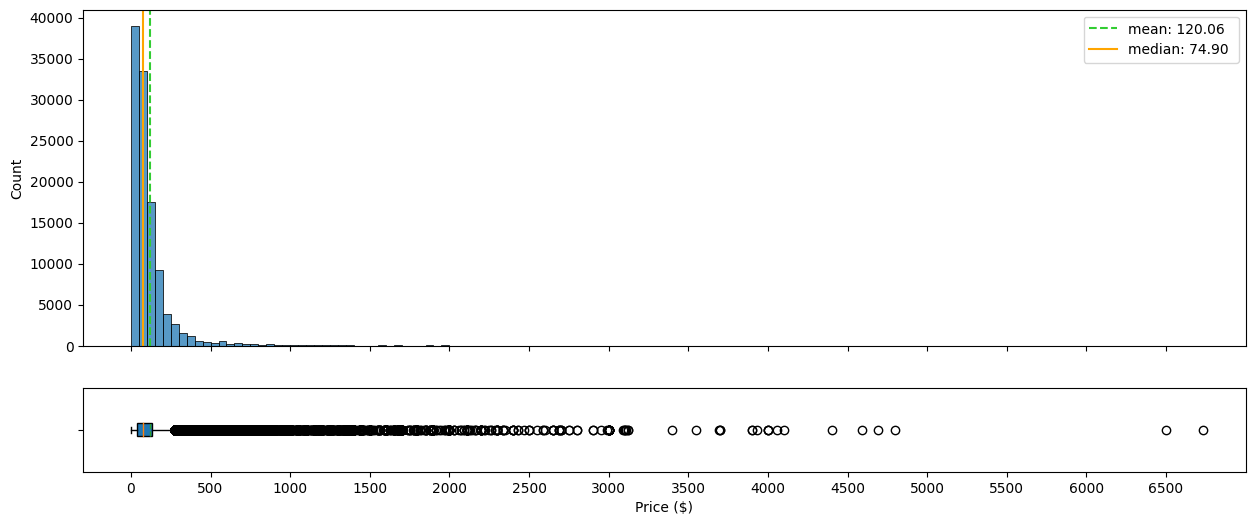

In [45]:
distboxplot(data=clean_data, column="price", bins=np.arange(0,7000,50),
            xticks=np.arange(0,7000,500), xlim=[-300,7000], xlabel="Price ($)", unit="",
            title=None, figsize=(15,6))

In [46]:
clean_data[clean_data["price"]>2000][["product_category_name_english", "price", "freight_value", "payment_value", "payment_type", "payment_sequential", "payment_installments"]]

product_category_name_english    price  freight_value  \
1134                          computers  2199.99          18.00   
1237                      watches_gifts  2999.00          17.01   
2012              computers_accessories  3699.99          36.23   
2170                         housewares  6735.00         194.31   
2718                          computers  3549.00          53.47   
...                                 ...      ...            ...   
110397                    watches_gifts  2299.00          24.25   
110398                    watches_gifts  2299.00          24.25   
111185  construction_tools_construction  2300.00          37.40   
112117  construction_tools_construction  2160.00          27.42   
112283  construction_tools_construction  2300.00          28.40   

        payment_value payment_type  payment_sequential  payment_installments  
1134          2217.99  credit_card                 1.0                  10.0  
1237          3016.01  credit_card                 1.0                   1.0  
2012          3736.22  credit_card                 1.0                  10.0  
2170          6929.31  credit_card                 1.0                   8.0  
2718          3602.47  credit_card                 1.0                   1.0  
...               ...          ...                 ...                   ...  
110397        2073.25  credit_card                 1.0                  10.0  
110398         250.00      voucher                 2.0                   1.0  
111185        2337.40  credit_card                 1.0                  10.0  
112117        2187.42  credit_card                 1.0                  10.0  
112283        2328.40  credit_card                 1.0                  10.0  

[116 rows x 7 columns]

**Freight Value**

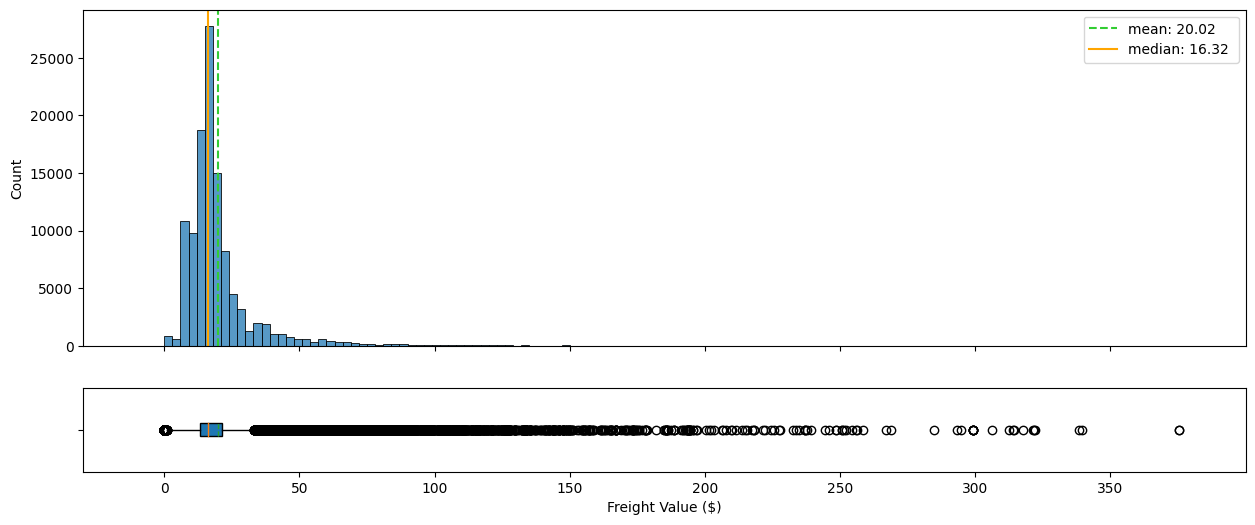

In [47]:
distboxplot(data=clean_data, column="freight_value", bins=np.arange(0,400,3),
            xticks=np.arange(0,400,50), xlim=[-30,400], xlabel="Freight Value ($)", unit="",
            title=None, figsize=(15,6))

In [48]:
clean_data[clean_data["freight_value"]>250][["product_category_name_english", "order_item_id", "price", "freight_value", "payment_value", "payment_type", "payment_sequential", "payment_installments"]]

product_category_name_english  order_item_id    price  \
11664                             health_beauty            1.0   760.00   
13958                             health_beauty            1.0   890.00   
15793                             health_beauty            1.0   990.00   
20476                             health_beauty            1.0  1050.00   
23225                             health_beauty            1.0  1050.00   
40454   kitchen_dining_laundry_garden_furniture            1.0   409.00   
40671           construction_tools_construction            1.0  1045.00   
70603                            sports_leisure            1.0   999.99   
75508                                      baby            1.0  1648.00   
76467                             health_beauty            1.0  1050.00   
78841                                      baby            1.0   979.00   
82154                                      baby            1.0  2699.00   
85042           construction_tools_construction            1.0   990.00   
87938                             health_beauty            1.0  1050.00   
91166                       musical_instruments            1.0  1899.00   
97199                              garden_tools            1.0   144.00   
98431                    signaling_and_security            1.0   175.00   
98432                    signaling_and_security            2.0   175.00   
98433                    signaling_and_security            3.0   175.00   
98434                    signaling_and_security            4.0   175.00   
98435                    signaling_and_security            5.0   175.00   
98436                    signaling_and_security            6.0   175.00   
99277                             health_beauty            1.0   760.00   
99324            industry_commerce_and_business            1.0  3089.00   
99921                       musical_instruments            1.0  1350.00   
100289                            health_beauty            1.0  1050.00   
100736                            health_beauty            1.0   550.00   
104383                               housewares            1.0  1149.00   
104596                               housewares            1.0  2338.08   
109275                               housewares            1.0  2338.08   
109790                         office_furniture            1.0   600.00   
109976                           sports_leisure            1.0  3099.00   

        freight_value  payment_value payment_type  payment_sequential  \
11664          312.41        1072.41  credit_card                 1.0   
13958          258.28        2067.42  credit_card                 1.0   
15793          314.02        1304.02       boleto                 1.0   
20476          250.57        1300.57  credit_card                 1.0   
23225          250.57        1300.57  credit_card                 1.0   
40454          251.39         660.39  credit_card                 1.0   
40671          314.40        1359.40  credit_card                 1.0   
70603          293.27        1293.26  credit_card                 1.0   
75508          254.55        1902.55  credit_card                 1.0   
76467          338.30        1388.30  credit_card                 1.0   
78841          409.68        1388.68  credit_card                 1.0   
82154          306.06        3005.06  credit_card                 1.0   
85042          321.46        1311.46  credit_card                 1.0   
87938          321.88        1371.88  credit_card                 1.0   
91166          284.60        2183.60  credit_card                 1.0   
97199          269.00         694.04  credit_card                 1.0   
98431          299.16        2844.96       boleto                 1.0   
98432          299.16        2844.96       boleto                 1.0   
98433          299.16        2844.96       boleto                 1.0   
98434          299.16        2844.96       boleto                 1.0   
98435    

**Payment Value**

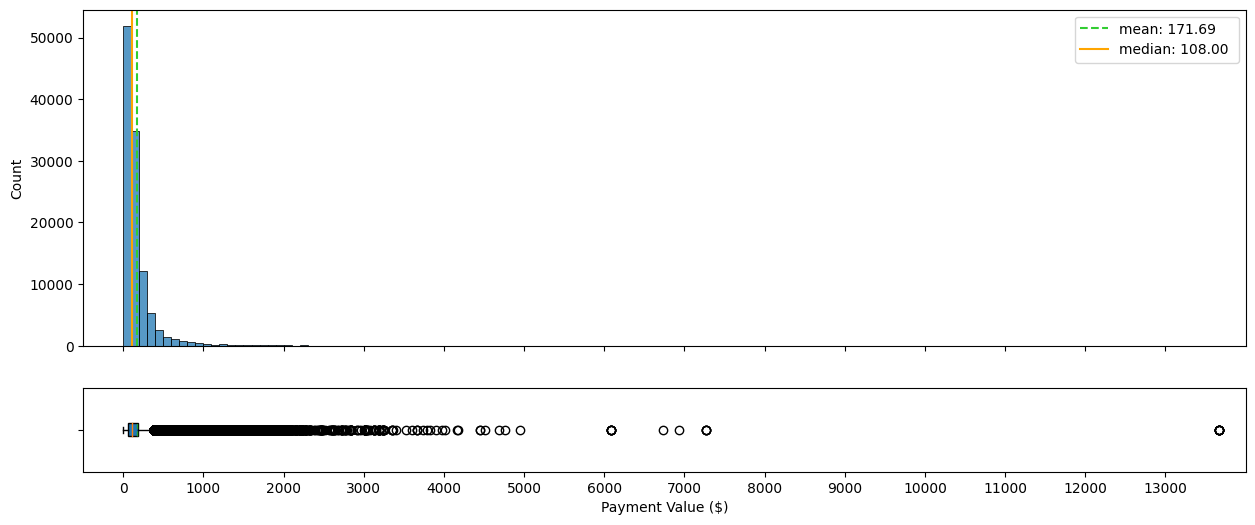

In [49]:
distboxplot(data=clean_data, column="payment_value", bins=np.arange(0,14000,100),
            xticks=np.arange(0,14000,1000), xlim=[-500,14000], xlabel="Payment Value ($)", unit="",
            title=None, figsize=(15,6))

In [50]:
clean_data[clean_data["payment_value"]>10000]

customer_unique_id                       customer_id  \
30719  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30720  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30721  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30722  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30723  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30724  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30725  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   
30726  0a0a92112bd4c708ca5fde585afaa872  1617b1357756262bfa56ab541c47bc16   

                               order_id order_status order_purchase_timestamp  \
30719  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30720  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30721  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30722  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30723  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30724  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30725  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   
30726  03caa2c082116e1d31e67e9ae3700499    delivered      2017-09-29 15:24:52   

        order_approved_at order_delivered_carrier_date  \
30719 2017-10-02 15:28:20          2017-10-10 15:43:17   
30720 2017-10-02 15:28:20          2017-10-10 15:43:17   
30721 2017-10-02 15:28:20          2017-10-10 15:43:17   
30722 2017-10-02 15:28:20          2017-10-10 15:43:17   
30723 2017-10-02 15:28:20          2017-10-10 15:43:17   
30724 2017-10-02 15:28:20          2017-10-10 15:43:17   
30725 2017-10-02 15:28:20          2017-10-10 15:43:17   
30726 2017-10-02 15:28:20          2017-10-10 15:43:17   

      order_delivered_customer_date order_estimated_delivery_date  \
30719           2017-10-17 18:22:29                    2017-10-23   
30720           2017-10-17 18:22:29                    2017-10-23   
30721           2017-10-17 18:22:29                    2017-10-23   
30722           2017-10-17 18:22:29                    2017-10-23   
30723           2017-10-17 18:22:29                    2017-10-23   
30724           2017-10-17 18:22:29                    2017-10-23   
30725           2017-10-17 18:22:29                    2017-10-23   
30726           2017-10-17 18:22:29                    2017-10-23   

       order_item_id                        product_id  \
30719            1.0  5769ef0a239114ac3a854af00df129e4   
30720            2.0  5769ef0a239114ac3a854af00df129e4   
30721            3.0  5769ef0a239114ac3a854af00df129e4   
30722            4.0  5769ef0a239114ac3a854af00df129e4   
30723            5.0  5769ef0a239114ac3a854af00df129e4   
30724            6.0  5769ef0a239114ac3a854af00df129e4   
30725            7.0  5769ef0a239114ac3a854af00df129e4   
30726            8.0  5769ef0a239114ac3a854af00df129e4   

                              seller_id shipping_limit_date   price  \
30719  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30720  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30721  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30722  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30723  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30724  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30725  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   
30726  b37c4c02bda3161a7546a4e6d222d5b2 2017-10-06 15:28:20  1680.0   

       freight_value product_category_name product_category_name_english  \
30719          28.01        telefonia_fixa               fixed_telephony   
30720          28.01        telefonia_fixa               fixed_telephony   
30721          28.01        telefonia_fixa               fixe

In [51]:
# clean_data["total_to_pay"] = (clean_data["price"] + clean_data["freight_value"]) * clean_data["order_item_id"]
# clean_data["overpaid"] = clean_data["total_to_pay"] - clean_data["payment_value"]
# distboxplot(data=clean_data, column="overpaid", bins=np.arange(-5000,14000,100),
#             xticks=np.arange(-5000,14000,1000), xlim=[-5000,14000], xlabel="Payment Value ($)", unit="",
#             title=None, figsize=(15,6))

In [52]:
# clean_data[clean_data["overpaid"]>1000]

#### **Categorical**

**Order Status**

<Axes: xlabel='order_status', ylabel='count'>

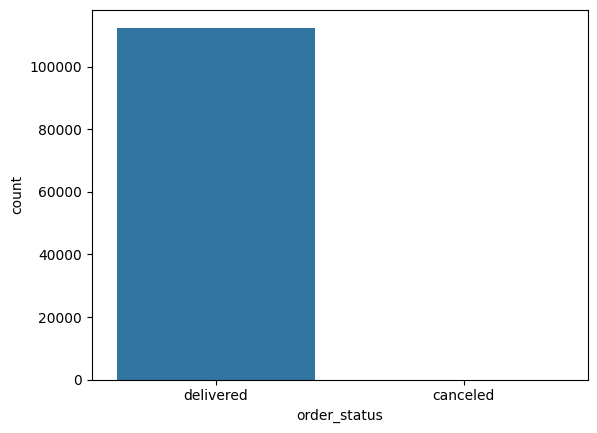

In [53]:
sns.countplot(data=clean_data, x="order_status")

**Product Category**

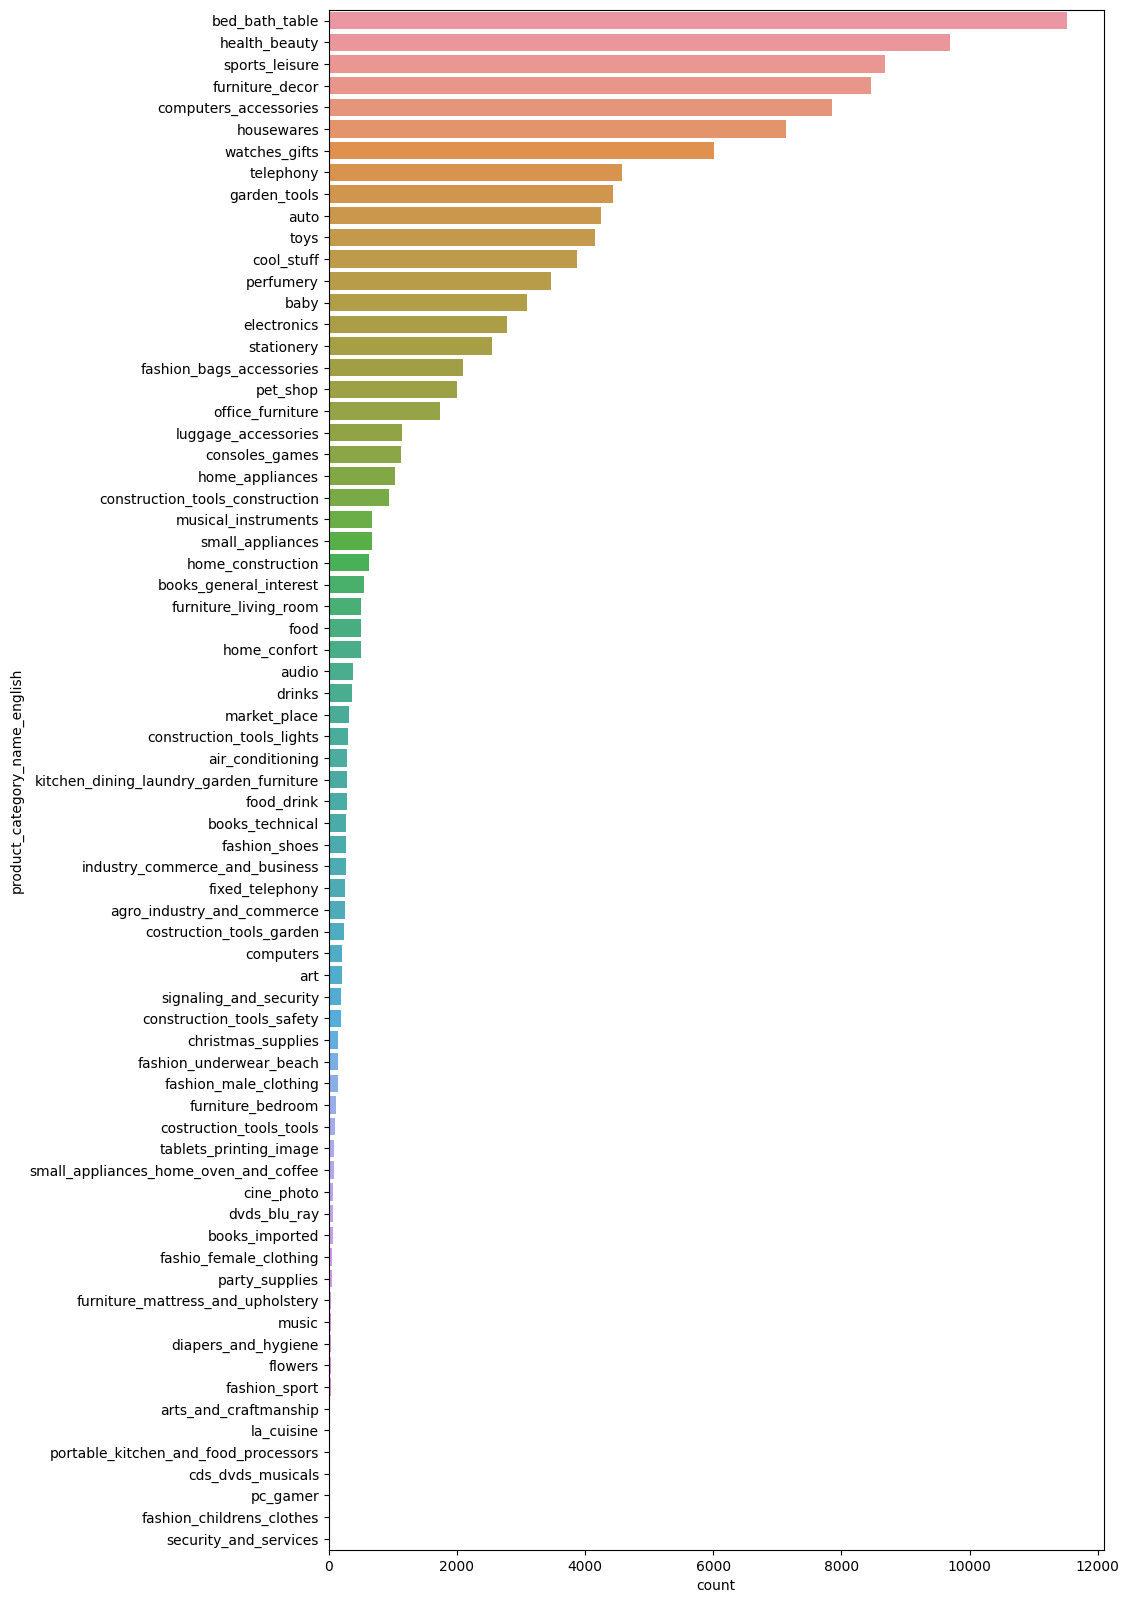

In [54]:
order = clean_data["product_category_name_english"].value_counts().index
plt.figure(figsize=(10,20))
sns.countplot(data=clean_data, y="product_category_name_english", order=order);

**Payment Type**

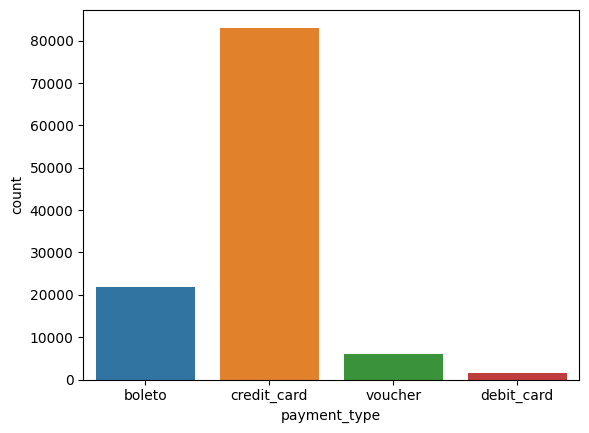

In [55]:
sns.countplot(data=clean_data, x="payment_type");

#### **Numerical, Ordinal**

**Payment Sequential**

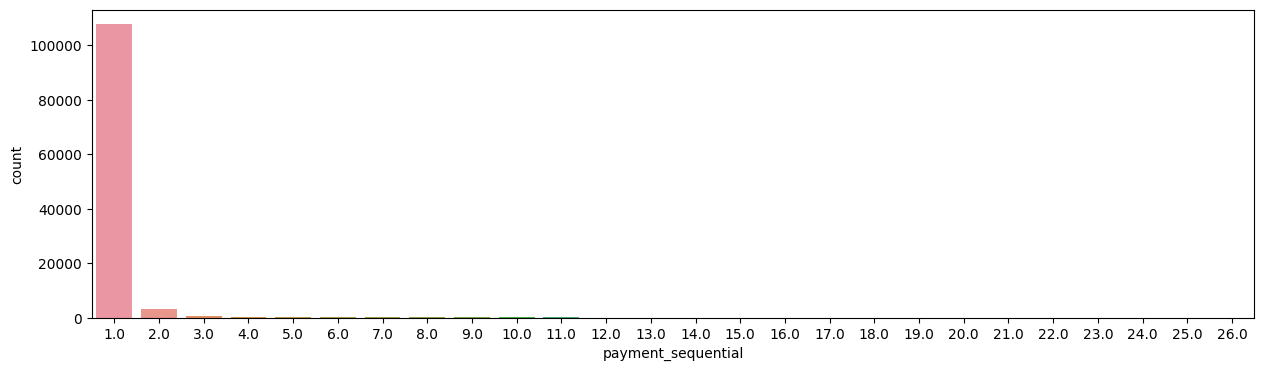

In [56]:
plt.figure(figsize=(15,4))
sns.countplot(data=clean_data, x="payment_sequential");

**Payment Installments**

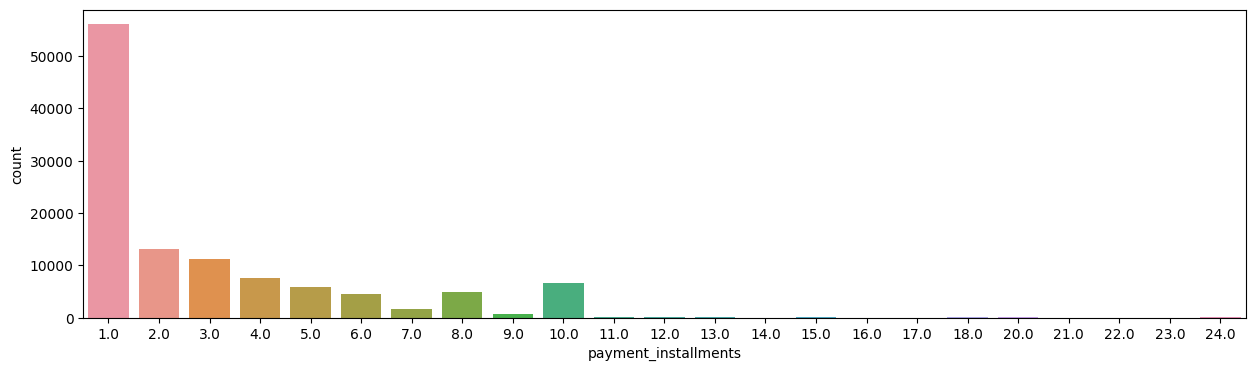

In [57]:
plt.figure(figsize=(15,4))
sns.countplot(data=clean_data, x="payment_installments");